# Flower Classification with Transfer Learning

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice I'd train this classifier, then export it for use in my application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use my trained model to perform inference on flower images.


By the end this project, I'll have an application that can be trained on any set of labeled images. Here my network will be learning about flowers and end up as a command line application.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

I'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: tensorflow in /root/.local/lib/python3.7/site-packages (2.9.1)
Note: you may need to restart the kernel to use updated packages.


After the above installations have finished **I'll have to restart the kernel**. 

In [2]:
# import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub


In [3]:
# Make all other necessary imports.
import matplotlib.pyplot as plt
import numpy as np
import json

In [4]:
# some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# ignore some warnings that are not relevant 
import warnings
warnings.filterwarnings('ignore')
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
tfds.disable_progress_bar()

## Load the Dataset

Here I'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  I'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but I'll still need to normalize and resize the images to the appropriate size.

In [7]:
!rm -rf ~/tensorflow_datasets/oxford_flowers102/
!rm -rf ~/tensorflow_datasets/downloads

In [8]:
# load the dataset with TensorFlow Datasets
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)
# create a training set, a validation set and a test set
train_data = dataset['train']
test_data = dataset['test']
val_data = dataset['validation']

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [10]:
# get the number of examples in each set from the dataset info
num_of_train_examples = dataset_info.splits['train'].num_examples
num_of_test_examples = dataset_info.splits['test'].num_examples
num_of_val_examples = dataset_info.splits['validation'].num_examples

print(f"Number of training examples: {num_of_train_examples}")
print(f"Number of testing examples: {num_of_test_examples}")
print(f"Number of validation examples: {num_of_val_examples}")

# get the number of classes in the dataset from the dataset info
num_classes = dataset_info.features['label'].num_classes

print(f"Number of classes: {num_classes}")

Number of training examples: 1020
Number of testing examples: 6149
Number of validation examples: 1020
Number of classes: 102


In [11]:
# print the shape and corresponding label of 3 images in the training set.
for image,label in train_data.take(3):
    print(f"Image shape: {image.shape} , Label: {label}")

Image shape: (500, 667, 3) , Label: 72
Image shape: (500, 666, 3) , Label: 84
Image shape: (670, 500, 3) , Label: 70


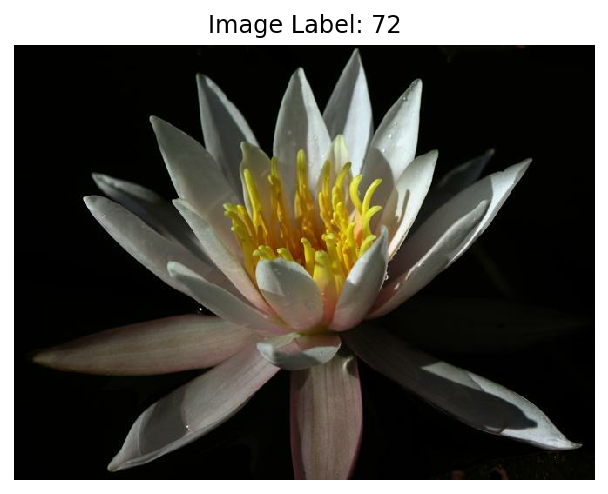

In [12]:
# plot 1 image from the training set. 
for image,label in train_data.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
# set the title of the plot to the corresponding image label.
plt.title(f"Image Label: {label}")
plt.axis("off");

### Label Mapping

I'll also need to load in a mapping from label to category name from the file `label_map.json`. This will give us a dictionary mapping the integer coded labels to the actual names of the flowers.

In [13]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [14]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

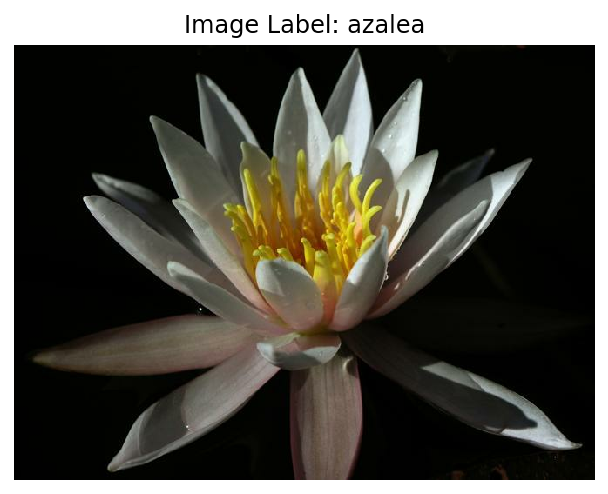

In [15]:
# plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
# plot 1 image from the training set. 
for image,label in train_data.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
# set the title of the plot to the corresponding image label.
plt.title(f"Image Label: {class_names[str(label)]}")
plt.axis("off");

## Create Pipeline

In [16]:
# create a pipeline for each set.
batch_size = 32
image_size = 224
@tf.autograph.experimental.do_not_convert
def rescale_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


train_batches = train_data.shuffle(num_of_train_examples//4).map(rescale_image).batch(batch_size).prefetch(1)
test_batches = test_data.map(rescale_image).batch(batch_size).prefetch(1)
validation_batches = val_data.map(rescale_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. I will use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.



Things I'll do next:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save my trained model as a Keras model.

In [17]:
# build my network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')])

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(optimizer = "adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [19]:
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

In [20]:
epochs = 65
history = model.fit(train_batches,epochs = epochs, validation_data = validation_batches, callbacks = [save_best,early_stopping])

Epoch 1/65
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - ETA: 0s - loss: 4.3055 - accuracy: 0.1137WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fadca9c7e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 47s 1s/step - loss: 4.3055 - accuracy: 0.1137 - val_loss: 3.1212 - val_accuracy: 0.3765
Epoch 2/65
32/32 

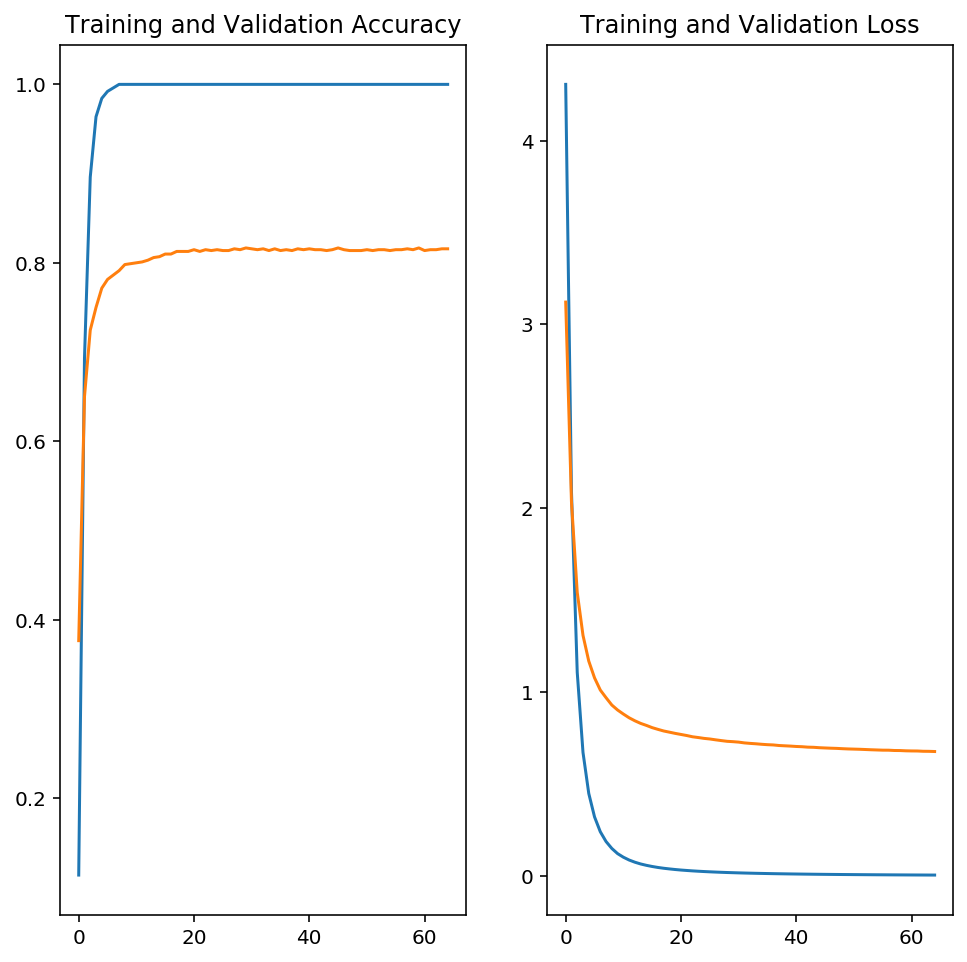

In [21]:
# plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss');

## Testing my Network

It's good practice to test my trained network on test data, images the network has never seen either in training or validation. This will give  a good estimate for the model's performance on completely new images.

In [22]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(test_batches)

print(f"Testing set loss: {loss}")
print(f"Testing set accuracy: {accuracy}")

193/193 [==============================] - 129s 669ms/step - loss: 0.8228 - accuracy: 0.7918
Testing set loss: 0.8227689862251282
Testing set accuracy: 0.7918360829353333


## Save the Model

Now that my network is trained, I will save the model so I can load it later for making inference.

In [23]:
# save my trained model as a Keras model.
model.save("./models/best_model.h5")

In [24]:
!ls

assets	       label_map.json			       test_images
best_model.h5  Project_Image_Classifier_Project.ipynb


## Load the Keras Model

In [25]:
# load the Keras model
loaded_model = tf.keras.models.load_model('./models/best_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Inference for Classification

Now I'll write a function that uses my trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

my `predict` function should use `PIL` to load the image from the given `image_path`. I'll use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. I'll convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by my model.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, I'll convert the image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, I'll also need to normalize the pixel values. 

Finally, I'll convert my image back to a NumPy array using the `.numpy()` method.

In [26]:
# create the process_image function
def process_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, [image_size, image_size])
    image /=255
    return image.numpy()

To check my `process_image` function I'll use 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by my `process_image` function. If my `process_image` function works, the plotted image should be the correct size. 

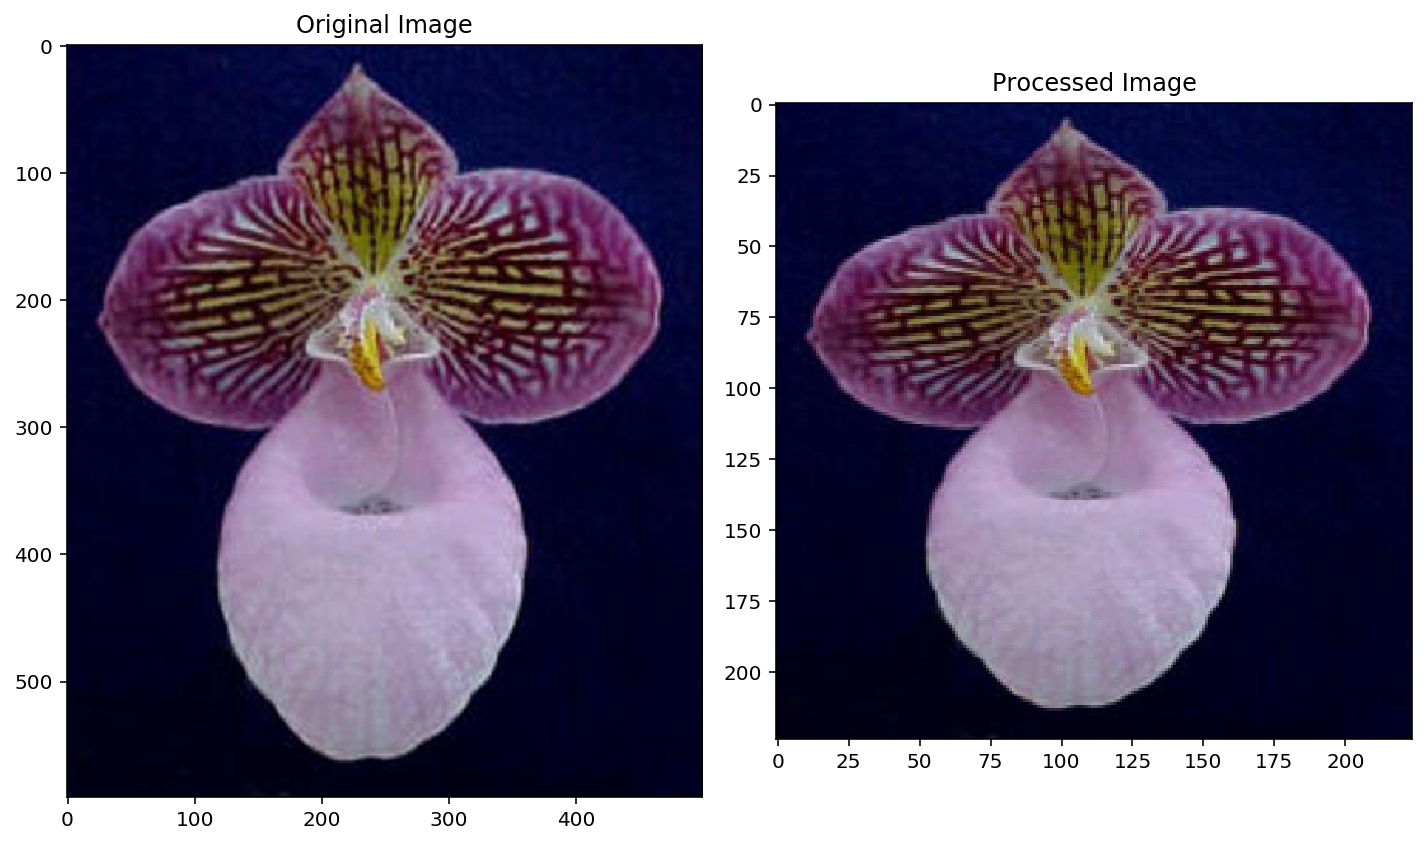

In [27]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

It's now time to write the `predict` function for making inference with my model.

### Inference

The `predict` function should will an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

my `predict` function should use `PIL` to load the image from the given `image_path`. I'll use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object.  

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. so I'll use use the `np.expand_dims()` function to add the extra dimension. 

In [28]:
# create the predict function
# reference: https://stackoverflow.com/questions/50640687/get-top-k-predictions-from-tensorflow
def predict(image_path, model, top_k):
    image = np.asarray(Image.open(image_path))
    processed_image = np.expand_dims(process_image(image), axis=0)
    probs = model.predict(tf.convert_to_tensor(processed_image))
    top_k_values, top_k_labels = tf.nn.top_k(probs, k=top_k)
    return image, top_k_values.numpy(), top_k_labels.numpy()

# Sanity Check

It's always good to check the predictions made by my model to make sure they are correct. To check my predictions I'll use 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below I'll use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by my model.

In [29]:
def get_name(classes):
    labels = []
    for i in range(top_k_labels.shape[1]):
        labels.append(class_names[str(top_k_labels[0][i]+1)])
    return labels

In [30]:
def plot_prediction(image, flower, probs, labels):
    fig, (ax1, ax2) = plt.subplots(figsize=(10,5),ncols=2)
    ax1.imshow(image)
    ax1.axis("off")
    ax1.set_title(f"Input Image: {flower.split('/')[-1]}")
    ax2.barh(np.arange(5),probs.squeeze())
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(labels)
    ax2.set_title("Class Probabilities")
    plt.tight_layout()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 53ms/step


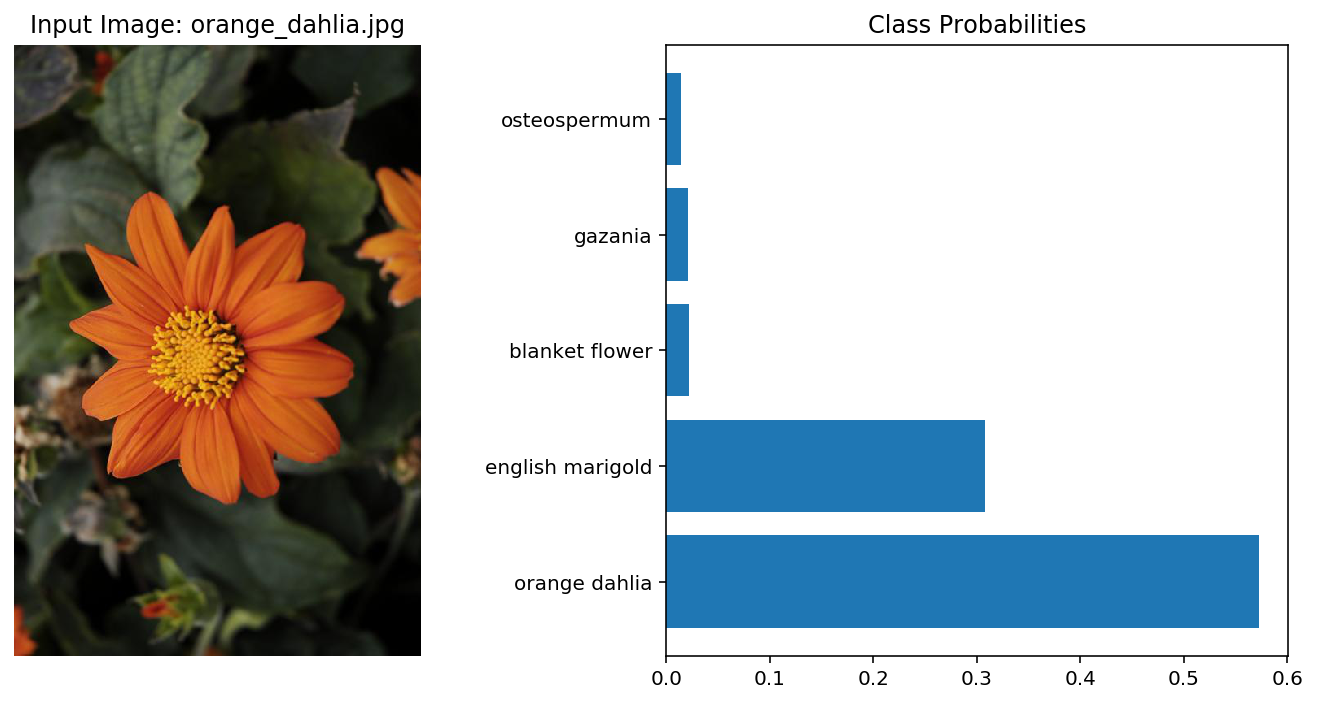

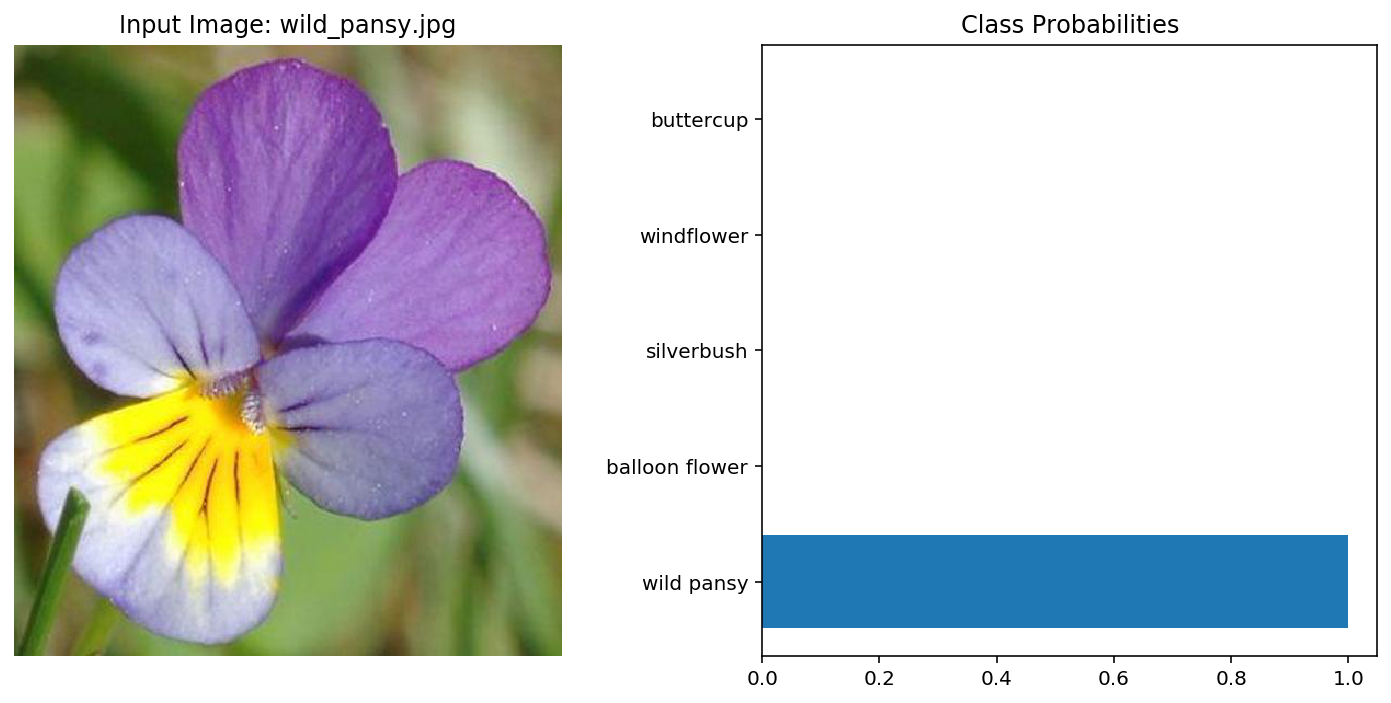

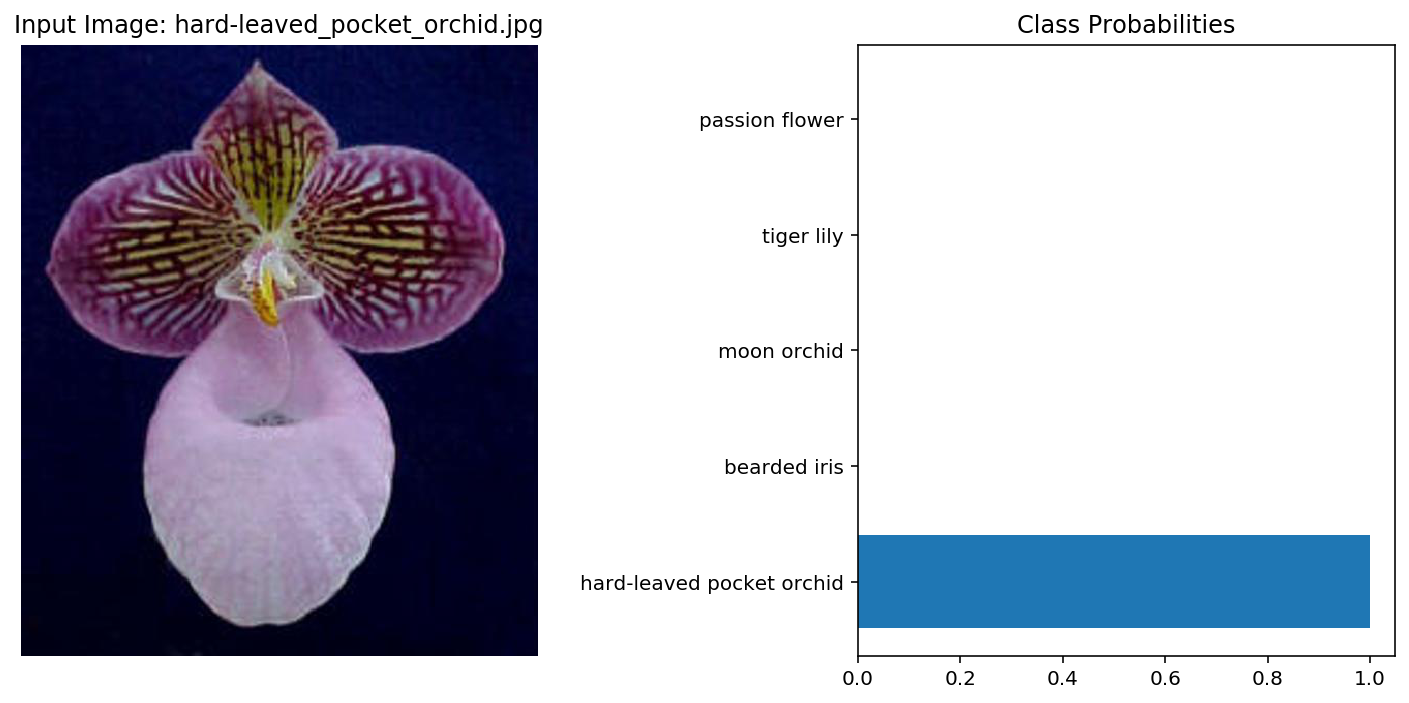

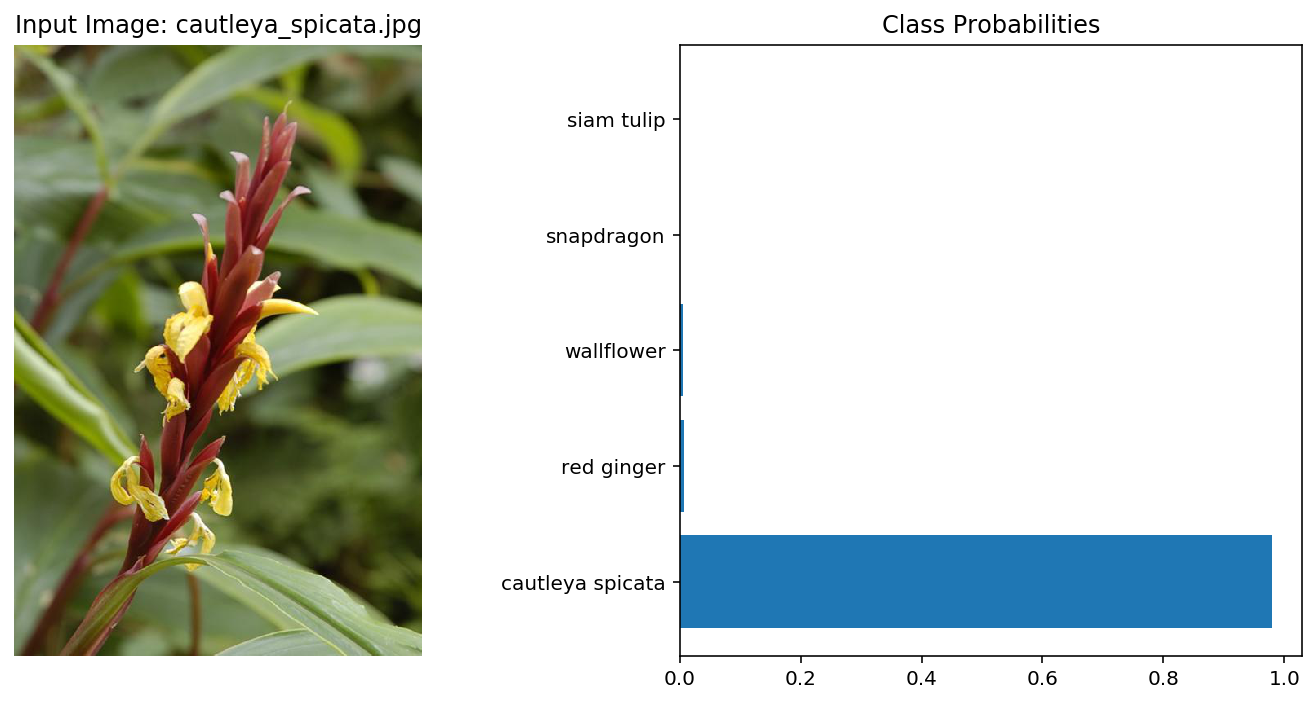

In [31]:
# plot the input image along with the top 5 classes
from glob import glob
flowers = np.array(glob("./test_images/*"))
for flower in flowers:
    image, top_k_probs, top_k_labels = predict(flower,loaded_model,5)
    labels = get_name(top_k_labels)
    plot_prediction(image, flower, top_k_probs, labels)